## Project: Wildfire Destructive Potential Index 

### Module 4: *Modeling*

---
### Contents  
- 1. Data Preperation
- 2. Random Forest
- 3. KNN Classifier
- 4. XGBoost
---
### Modeling strategy:
This module automatically finds the optimal configuration of models based on the average F1 score of all three categories.

**WARNING** this module is very computation heavy
- Start with a **baseline model** for comparison.
- Test with multi-classification **tree-based models** (Random Forest, XGBoost) and KNN.
- Use kfold **cross-validation** to tune hyperparameters for each model.
- Export optimal models

---
### Inputs
- `X.csv`- cleaned and scaled main weather dataset
- `y.csv`- multiclass target (0,1,2)

---
### Outputs  

`model_parameters.csv` - optimal parameters for each of the three models

---
### User Created Dependencies

In [1]:
# Add the parent directory to the system path so "src" can be found
import sys
import os
sys.path.append(os.path.abspath(os.path.join('..')))

# user built utilities
from src.model_utils import gen_report
from src.model_utils import kfold

---

### Third Party Dependencies

In [2]:
# Core Python libraries
import numpy as np
import pandas as pd

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Preprocessing and modeling
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report

# Resampling tools
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import SMOTE

# XGBoost
import xgboost as xgb

# Suppress warnings for cleaner output
import warnings
warnings.filterwarnings('ignore')

# Style
sns.set(style='whitegrid')
plt.rcParams["figure.dpi"] = 100

In [3]:
# Load processed feature and label data
best_strategy = pd.read_csv('../data/processed/best_strategy.csv')
X = pd.read_csv('../data/processed/X.csv')
y = pd.read_csv('../data/processed/y.csv').squeeze()

## 1. Data Preparation

### 1.1 Split data

In [5]:
def manual_undersampling(X_train, y_train):
    
    # Sample 3,000 'Low' cases
    low_indices = y_train[y_train == 0].sample(n=2000, random_state=42).index

    # Get all 'Moderate' and 'High' indices
    other_indices = y_train[y_train != 0].index

    # Combine sampled 'Low' with all others
    final_indices = low_indices.union(other_indices)

    # Subset X and y
    X_train = X_train.loc[final_indices].reset_index(drop=True)
    y_train = y_train.loc[final_indices].reset_index(drop=True)
    
    return X_train, y_train

In [6]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

### 1.2 Balance Data

In [7]:
best_strategy

,Unnamed: 0,Model_Label,Best_Strategy
0,0,KNN,No_balance
1,1,Random Forest,No_balance
2,2,XGBoost,Oversampling


In [8]:
smote = SMOTE()
over_X_train, over_y_train = smote.fit_resample(X_train, y_train)

## 2. Random Forest Classifier

This section evaluates Hypertuning and class-balancing options for SciKitLearns **RandomForestClassifier**. Options are tested utilizing kfold validation. 
- `n_estimators` [50, 100, 150]
- `max_depth` [5, 10, 15, 20]
- `min_samples_split_values` = [2, 5, 10, 20, 50]
- `max_features` ['sqrt', 'log2']

### 2.1 Hyperparameter Tuning

#### Number of Estimators (n_estimators)

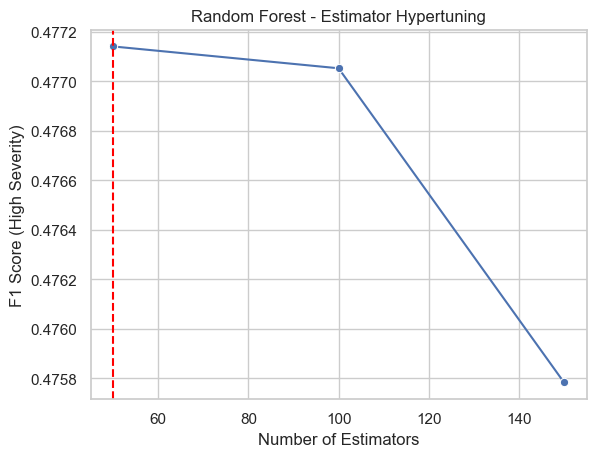

In [9]:
# Define parameter grid
n_estimators = [50, 100, 150]
F1_values = []

# Perform k-fold cross-validation for each value
for n in n_estimators:
    rf = RandomForestClassifier(n_estimators=n, max_depth=10,
                                min_samples_split=10, max_features='sqrt',
                                class_weight='balanced')
    reports = kfold(X_train, y_train, rf)
    Train_metrics = gen_report(reports)
    average_f1 = Train_metrics['F1-Score'].sum() / len(Train_metrics['F1-Score'])
    F1_values.append(average_f1)

# identify and save highest F1 score
optimum_n_estimator = n_estimators[F1_values.index(max(F1_values))]

sns.lineplot(x=n_estimators, y=F1_values, marker='o')
plt.axvline(optimum_n_estimator, color='red', linestyle='--', label=f'Best: {optimum_n_estimator}')
plt.xlabel('Number of Estimators')
plt.ylabel('F1 Score (High Severity)')
plt.title("Random Forest - Estimator Hypertuning")
plt.show()

In [10]:
optimum_n_estimator

50

#### Maximum Tree Depth (max_depth)

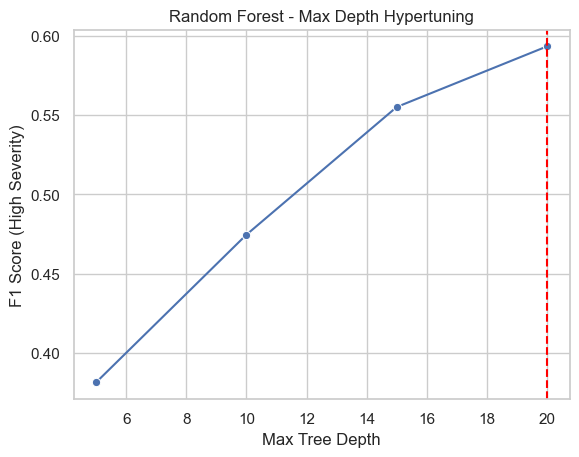

In [11]:
max_depth = [5, 10, 15, 20]
F1_values = []

for depth in max_depth:
    rf = RandomForestClassifier(n_estimators=optimum_n_estimator,
                                max_depth=depth, min_samples_split=10,
                                class_weight='balanced')
    reports = kfold(X_train, y_train, rf)
    Train_metrics = gen_report(reports)
    average_f1 = Train_metrics['F1-Score'].sum() / len(Train_metrics['F1-Score'])
    F1_values.append(average_f1)

# Find the depth that gave the highest F1 score
optimum_max_depth = max_depth[F1_values.index(max(F1_values))]

sns.lineplot(x=max_depth, y=F1_values, marker='o')
plt.axvline(optimum_max_depth, color='red', linestyle='--', label=f'Best: {optimum_max_depth}')
plt.xlabel('Max Tree Depth')
plt.ylabel('F1 Score (High Severity)')
plt.title("Random Forest - Max Depth Hypertuning")
plt.show()

In [12]:
optimum_max_depth

20

#### Maximum Features (max_features)

In [13]:
max_features = ['sqrt', 'log2']
F1_values = []

for features in max_features:
    rf = RandomForestClassifier(n_estimators=optimum_n_estimator,
                                max_depth=optimum_max_depth,
                                min_samples_split=10,
                                max_features=features,
                                class_weight='balanced')
    reports = kfold(X_train, y_train, rf)
    Train_metrics = gen_report(reports)
    
    average_f1 = Train_metrics['F1-Score'].sum() / len(Train_metrics['F1-Score'])
    F1_values.append(average_f1)
    
    print("Performance Metrics for :", features)
    display(Train_metrics)
    
best_index = F1_values.index(max(F1_values))

# Final choice based on prior evaluations
optimum_max_features = max_features[best_index]

Performance Metrics for : sqrt


,Category,Precision,Recall,F1-Score
0,0,0.951736,0.927554,0.939489
1,1,0.416385,0.507691,0.457485
2,2,0.318459,0.464638,0.377298


Performance Metrics for : log2


,Category,Precision,Recall,F1-Score
0,0,0.951822,0.928294,0.939909
1,1,0.417397,0.508539,0.458451
2,2,0.318836,0.451911,0.373365


In [14]:
optimum_max_features

'sqrt'

#### Minimum Sample Split  (min_samples)

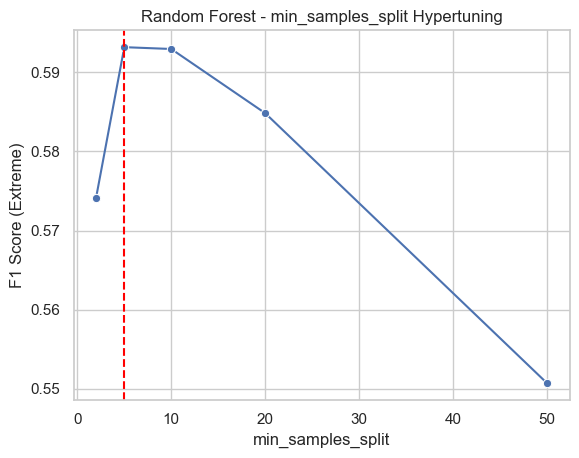

In [15]:
min_samples_split_values = [2, 5, 10, 20, 50]
F1_values = []

for split in min_samples_split_values:
    rf = RandomForestClassifier(
        n_estimators=optimum_n_estimator,
        max_depth=optimum_max_depth,
        min_samples_split=split,
        max_features=optimum_max_features,
        class_weight='balanced'
    )
    reports = kfold(X_train, y_train, rf)
    Train_metrics = gen_report(reports)
    
    average_f1 = Train_metrics['F1-Score'].sum() / len(Train_metrics['F1-Score'])
    F1_values.append(average_f1)

# Find the best value
best_index = F1_values.index(max(F1_values))
optimum_min_samples_split = min_samples_split_values[best_index]

sns.lineplot(x=min_samples_split_values, y=F1_values, marker='o')
plt.axvline(optimum_min_samples_split, color='red', linestyle='--', label=f'Best: {optimum_min_samples_split}')
plt.xlabel('min_samples_split')
plt.ylabel('F1 Score (Extreme)')
plt.title('Random Forest - min_samples_split Hypertuning')
plt.show()

### 2.2 Final Random Forest Model

In [16]:
RF_parameters = {
    'n_estimators': optimum_n_estimator,
    'max_depth': optimum_max_depth,
    'min_samples_split': optimum_min_samples_split,
    'max_features': optimum_max_features,
    'class_weight':'balanced'
}

optimum_rf = RandomForestClassifier(**RF_parameters)

# Create DataFrame and format display
pd.DataFrame([RF_parameters]).style \
    .hide(axis='index') \
    .set_caption("Optimum Random Forest Parameters")

n_estimators,max_depth,min_samples_split,max_features,class_weight
50,20,5,sqrt,balanced


### 2.3 Evaluation Under Different Sampling Strategies

## 3. K-Nearest Neighbors (KNN) Classifier

This section explores hyperparameter tuning and evaluation of a KNN model using a grid search and various resampling strategies.

parameters tested:
- `n_neighbors` 3 to 10
- `weights` ['uniform', 'distance']

### 3.1 Hyperparameter Tuning with GridSearchCV

In [17]:
# Define KNN model and parameter grid
knn = KNeighborsClassifier()
param_grid = {
    'n_neighbors': list(range(20)),
    'weights': ['uniform', 'distance']
}

# GridSearchCV with 5-fold cross-validation, macro F1 score
grid_search = GridSearchCV(estimator=knn, param_grid=param_grid,
                           cv=5, scoring='f1_macro')

# Fit the model to training data
grid_search.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=KNeighborsClassifier(),
             param_grid={'n_neighbors': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11,
                                         12, 13, 14, 15, 16, 17, 18, 19],
                         'weights': ['uniform', 'distance']},
             scoring='f1_macro')

#### Grid Search Results Visualization

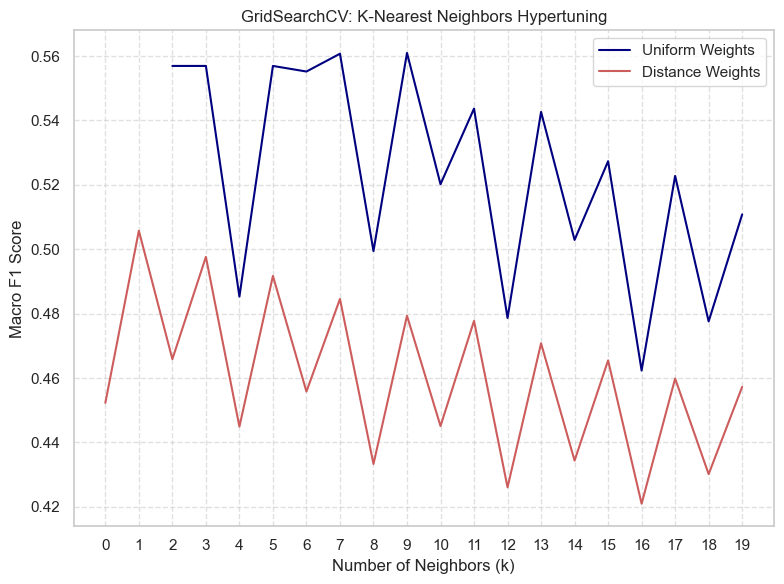

In [18]:
# Extract mean test scores and reshape by weight type
mean_test_scores = grid_search.cv_results_['mean_test_score']
k_values = list(range(20))
results_matrix = np.array(mean_test_scores).reshape(2, 20)

# Plotting the F1 score across different k values and weight schemes
plt.figure(figsize=(8, 6))
plt.plot(k_values, results_matrix[0], label='Uniform Weights', color='navy')
plt.plot(k_values, results_matrix[1], label='Distance Weights', color='indianred')

plt.title("GridSearchCV: K-Nearest Neighbors Hypertuning")
plt.xlabel("Number of Neighbors (k)")
plt.ylabel("Macro F1 Score")
plt.xticks(k_values)
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

### 3.2 Final KNN Model

In [19]:
knn_parameters = grid_search.best_params_

optimum_knn = KNeighborsClassifier(**knn_parameters)

# Create DataFrame and format display
pd.DataFrame([knn_parameters]).style \
    .hide(axis='index') \
    .set_caption("Optimum KNN Parameters")

n_neighbors,weights
4,distance


## 4. XGBoost Classifier

This section trains an XGBoost classifier using grid-based hyperparameter tuning and evaluates performance under different sampling strategies.

### 4.2 Hyperparameter Tuning

#### n_estimators Tuning

.
.
.
.


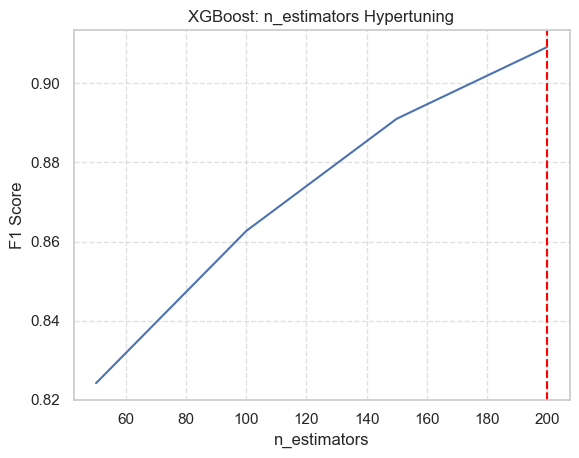

In [20]:
n_estimators = [50, 100, 150, 200]
F1_values = []
metrics_list = []

for n in n_estimators:
    xgb_model = xgb.XGBClassifier(
        objective='multi:softmax',
        num_class=3,
        learning_rate=0.1,
        max_depth=6,
        n_estimators=n
    )
    print(".")
    reports = kfold(over_X_train, over_y_train, xgb_model)
    Train_metrics = gen_report(reports)
    average_f1 = Train_metrics['F1-Score'].sum() / len(Train_metrics['F1-Score'])
    F1_values.append(average_f1)

# Find and save the n_estimators value with the highest F1 score
best_index = F1_values.index(max(F1_values))
XGB_optimum_n_estimator = n_estimators[best_index]

sns.lineplot(x=n_estimators, y=F1_values)
plt.axvline(XGB_optimum_n_estimator, color='red', linestyle='--', label=f'Best: {XGB_optimum_n_estimator}')
plt.xlabel('n_estimators')
plt.ylabel('F1 Score')
plt.title('XGBoost: n_estimators Hypertuning')
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()   

#### learning_rate Tuning

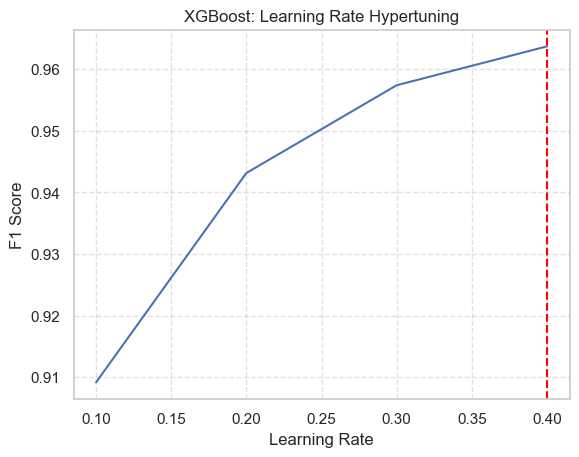

In [21]:
learning_rates = [0.1, 0.2, 0.3, 0.4]
F1_values = []

for rate in learning_rates:
    xgb_model = xgb.XGBClassifier(
        objective='multi:softmax',
        num_class=3,
        learning_rate=rate,
        max_depth=6,
        n_estimators=200
    )
    
    reports = kfold(over_X_train, over_y_train, xgb_model)
    Train_metrics = gen_report(reports)
    average_f1 = Train_metrics['F1-Score'].sum() / len(Train_metrics['F1-Score'])
    F1_values.append(average_f1)

# Find and save the learning rate value with the highest F1 score
best_index = F1_values.index(max(F1_values))
optimum_learning_rate = learning_rates[best_index]

sns.lineplot(x=learning_rates, y=F1_values)
plt.axvline(optimum_learning_rate, color='red', linestyle='--', label=f'Best: {optimum_learning_rate}')
plt.xlabel('Learning Rate')
plt.ylabel('F1 Score')
plt.title('XGBoost: Learning Rate Hypertuning')
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()

#### max_depth Tuning

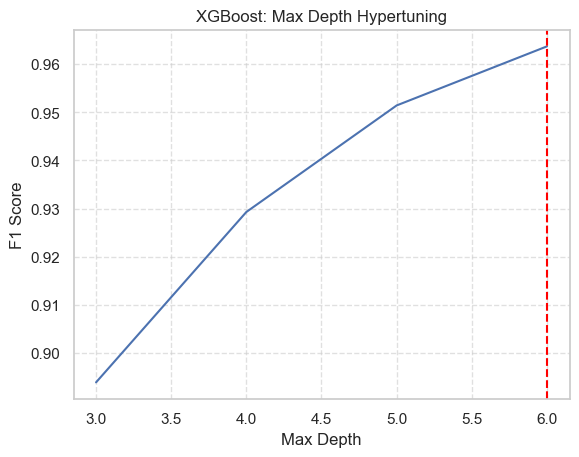

In [22]:
max_depths = [3, 4, 5, 6]
F1_values = []

for depth in max_depths:
    xgb_model = xgb.XGBClassifier(
        objective='multi:softmax',
        num_class=3,
        learning_rate=0.4,
        max_depth=depth,
        n_estimators=200
    )
    
    reports = kfold(over_X_train, over_y_train, xgb_model)
    Train_metrics = gen_report(reports)
    average_f1 = Train_metrics['F1-Score'].sum() / len(Train_metrics['F1-Score'])
    F1_values.append(average_f1)

# Find and save the max depth with the highest F1 score
best_index = F1_values.index(max(F1_values))
XGB_optimum_max_depth = max_depths[best_index]

sns.lineplot(x=max_depths, y=F1_values)
plt.axvline(XGB_optimum_max_depth, color='red', linestyle='--', label=f'Best: {XGB_optimum_max_depth}')
plt.xlabel('Max Depth')
plt.ylabel('F1 Score')
plt.title('XGBoost: Max Depth Hypertuning')
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()   

### 4.3 Final XGBoost Model

In [23]:
XGB_parameters = {
    'objective': 'multi:softmax',
    'num_class': 3,
    'n_estimators': XGB_optimum_n_estimator,
    'max_depth': XGB_optimum_max_depth,
    'learning_rate': optimum_learning_rate,
}


optimum_xgb_model = xgb.XGBClassifier(
    **XGB_parameters
)

# Create DataFrame and format display
pd.DataFrame([XGB_parameters]).style \
    .hide(axis='index') \
    .set_caption("Optimum XGBoost Parameters")

objective,num_class,n_estimators,max_depth,learning_rate
multi:softmax,3,200,6,0.400000


## Export

In [24]:
model_params = {
    'RandomForest': RF_parameters,
    'XGBoost': XGB_parameters,
    'KNN': knn_parameters
}
# Flatten the dict into a DataFrame
model_parameters = pd.DataFrame.from_dict(model_params, orient='index')

# Save to CSV
model_parameters.to_csv('../data/processed/model_parameters.csv')
